### Notebook is based on sparkoverflow data dump from 2017-03-14

In [1]:
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = (SparkSession.builder
    .config('spark.executor.memoty', 2800)
    .appName('appname')
    .getOrCreate())

In [2]:
posts = spark.read.parquet('/data/Posts/*')
votes = spark.read.parquet('/data/Votes/*')
users = spark.read.parquet('/data/Users/*')
comments = spark.read.parquet('/data/Comments')

### Do questions ended with a question mark have bigger chance of being answered?

Number of posts

In [3]:
posts.count()

34857917

Number of questions

In [4]:
questions_count = posts.where(col('PostTypeId') == 1).count()
questions_count

13472796

How many questions ends with question mark?

In [5]:
ends_with_qm = col('Title').like('%?').alias('ends_with_qm')
as_percent = lambda col: round(col * 100, 2)

posts.where(posts.PostTypeId == 1).groupBy(ends_with_qm).count() \
    .withColumn('percent', as_percent(col('count') / questions_count)).show()

+------------+--------+-------+
|ends_with_qm|   count|percent|
+------------+--------+-------+
|        true| 2905334|  21.56|
|       false|10567462|  78.44|
+------------+--------+-------+



How many questions in each group is answered?

In [6]:
question_aswered = col('AcceptedAnswerId').isNotNull()
posts.where(posts.PostTypeId == 1) \
    .withColumn('ends_with_qm', col('Title').like('%?')) \
    .withColumn('answered', question_aswered.cast('int')) \
    .groupBy('ends_with_qm').agg(count('*'), sum(col('answered'))) \
    .withColumn('solving_chance', as_percent(col('sum(answered)') / col('count(1)'))).show()

+------------+--------+-------------+--------------+
|ends_with_qm|count(1)|sum(answered)|solving_chance|
+------------+--------+-------------+--------------+
|        true| 2905334|      1722170|         59.28|
|       false|10567462|      5577074|         52.78|
+------------+--------+-------------+--------------+



Percent of answered questions by tag

In [7]:
answered_by_tag = posts.where(posts.PostTypeId == 1) \
    .withColumn('ends_with_qm', col('Title').like('%?')) \
    .withColumn('answered', question_aswered.cast('int')) \
    .withColumn('tag', explode('Tags')) \
    .groupBy('tag', 'ends_with_qm').agg(count('*'), sum(col('answered'))) \
    .withColumn('solving_chance', as_percent(col('sum(answered)') / col('count(1)'))).cache()
answered_by_tag.show()

+-------------------+------------+--------+-------------+--------------+
|                tag|ends_with_qm|count(1)|sum(answered)|solving_chance|
+-------------------+------------+--------+-------------+--------------+
|internet-explorer-8|        true|    1328|          768|         57.83|
|    exchange-server|        true|     639|          285|          44.6|
|   django-flatpages|       false|      75|           47|         62.67|
| composite-controls|       false|      78|           47|         60.26|
|          protected|       false|     559|          333|         59.57|
|    code-inspection|        true|      37|           25|         67.57|
|       localization|        true|    2612|         1592|         60.95|
|    sharepoint-2007|       false|    2442|         1303|         53.36|
|               mask|        true|     312|          171|         54.81|
|      string-search|       false|     122|           73|         59.84|
|  social-networking|       false|    1399|        

Difference between solving chances for each tag

In [8]:
answered_by_tag \
    .withColumn('solving_chance', when(col('ends_with_qm'), 1).otherwise(-1) * col('solving_chance')) \
    .groupBy('tag').agg(round(sum('solving_chance'), 2).alias('diff'), sum('count(1)').alias('total_questions')) \
    .orderBy(desc('diff')) \
    .where(col('total_questions') > 1000).show()

+---------------+-----+---------------+
|            tag| diff|total_questions|
+---------------+-----+---------------+
|    multiplayer|18.67|           1006|
|       identity|18.56|           1767|
|        ejb-3.1|18.45|           1027|
|    ioexception|18.26|           1067|
|  impersonation|18.17|           1163|
|      uploadify|18.02|           1134|
|         axapta| 18.0|           1985|
|         ibm-mq|16.99|           2352|
|      configure|16.89|           1081|
|            nib|16.67|           1031|
| apache-commons|16.65|           1304|
|azure-web-roles|16.45|           1096|
|       checkout|16.36|           1785|
|         shared|16.22|           1129|
|           seam|16.16|           1389|
|      web-parts|16.15|           1564|
|          using|15.81|           1206|
|      semantics|15.78|           1370|
|    perl-module|15.75|           1261|
|         xdebug| 15.7|           2007|
+---------------+-----+---------------+
only showing top 20 rows



In [9]:
answered_by_tag.where(col('tag') == 'ioexception').show()

+-----------+------------+--------+-------------+--------------+
|        tag|ends_with_qm|count(1)|sum(answered)|solving_chance|
+-----------+------------+--------+-------------+--------------+
|ioexception|       false|     921|          450|         48.86|
|ioexception|        true|     146|           98|         67.12|
+-----------+------------+--------+-------------+--------------+



### The most controversial posts

In [10]:
upvote = (col('VoteTypeId') == 2).cast('int')
downvote = (col('VoteTypeId') == 3).cast('int')
votes.repartition(200).groupBy('PostId').agg(
        sum(upvote).alias('sum(upvote)'), sum(downvote) .alias('sum(downvote)')
    ).join(posts, posts.Id == votes.PostId) \
    .where(col('sum(downvote)') > 0.5 * col('sum(upvote)')).orderBy(desc('sum(upvote)')) \
    .select(posts.Id, posts.ParentId, 'sum(upvote)', 'sum(downvote)').show()

+--------+--------+-----------+-------------+
|      Id|ParentId|sum(upvote)|sum(downvote)|
+--------+--------+-----------+-------------+
|18018493|  244777|        380|          228|
|  871420|  871405|        364|          227|
| 2155787| 2155737|        246|          135|
|  170968|  170961|        176|           93|
| 1661249| 1661197|        154|           95|
| 1641305| 1641219|        135|          102|
|11284322|11284321|        112|           64|
|13866306| 5275098|        112|           80|
| 8439617| 1026069|        111|           77|
| 1427133|  758212|        106|           67|
|13519990|    null|        102|          153|
| 4110601| 1653308|         99|           88|
| 4082976| 4082966|         98|           86|
|  877516|       9|         95|           54|
|   77966|   38210|         93|           49|
| 2044046| 2044033|         85|           44|
|     357|      13|         85|          132|
|  285870|  285717|         84|           70|
| 1376114| 1376077|         77|   

The most controversial post: http://stackoverflow.com/questions/244777/can-comments-be-used-in-json/18018493#18018493

### Answers to posts ratio

In [11]:
users_aq = posts.where(col('PostTypeId').isin(1, 2)).select(
        'OwnerUserId', 
        when(col('PostTypeId') == 1, 1).alias('question'),
        when(col('PostTypeId') == 2, 1).alias('answer')
    ).groupBy('OwnerUserId').agg(sum('question'), sum('answer'), count('*').alias('all_posts')).cache()
users_aq.show()

+-----------+-------------+-----------+---------+
|OwnerUserId|sum(question)|sum(answer)|all_posts|
+-----------+-------------+-----------+---------+
|     100170|           10|         19|       29|
|      61793|           21|         21|       42|
|      87616|           16|        118|      134|
|      36131|           42|         22|       64|
|       1580|           22|         50|       72|
|      73048|           76|         47|      123|
|      65408|            2|       null|        2|
|      92182|           48|         98|      146|
|      20382|           47|        461|      508|
|     102793|            8|         89|       97|
|      91299|           44|       1638|     1682|
|      25462|           29|         41|       70|
|      20683|           29|         72|      101|
|     102960|           48|         24|       72|
|       1959|           20|         29|       49|
|      64519|          152|         93|      245|
|      46994|           24|         15|       39|


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

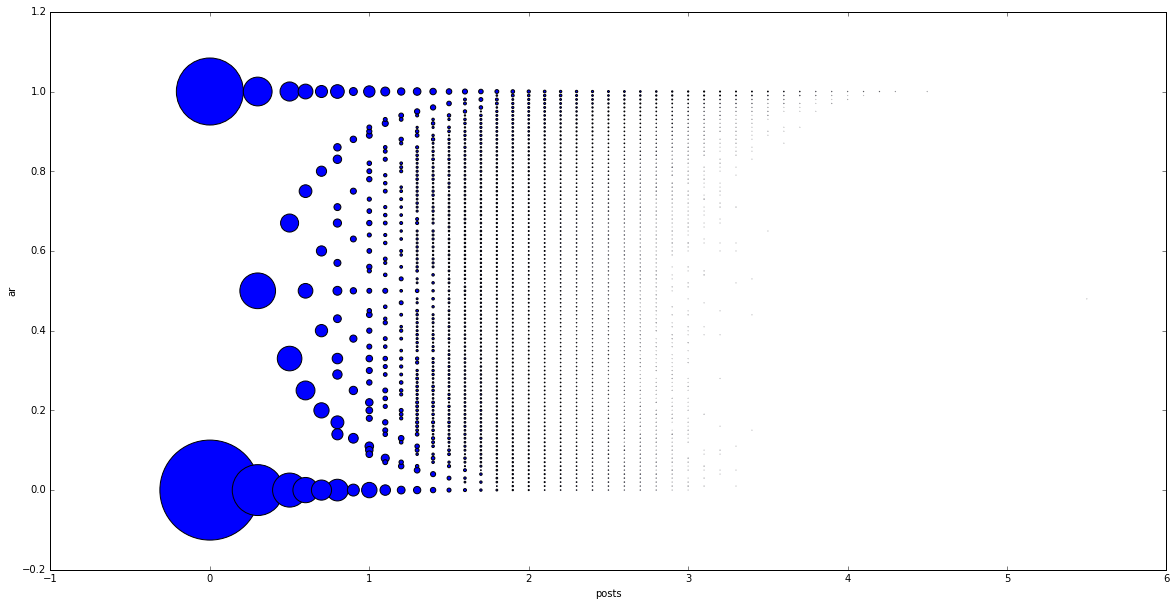

In [13]:
df = users_aq.withColumn('answer_rate', coalesce(col('sum(answer)') / col('all_posts'), lit(0))) \
    .withColumn('log10_posts', log10('all_posts')) \
    .select(round('answer_rate', 2).alias('ar'), round('log10_posts', 1).alias('posts')) \
    .groupBy('ar', 'posts').count().orderBy(desc('count')).toPandas()
    
df.plot(x='posts', y='ar', kind='scatter', s=df['count'] / df['count'].max() * 10000)

The above charts shows group of users depending of number of posts (normalized to log10(number_of_posts)) on X axis and percent of answers in all posts on Y axis. The bigger dot is, the more users there are inside group.

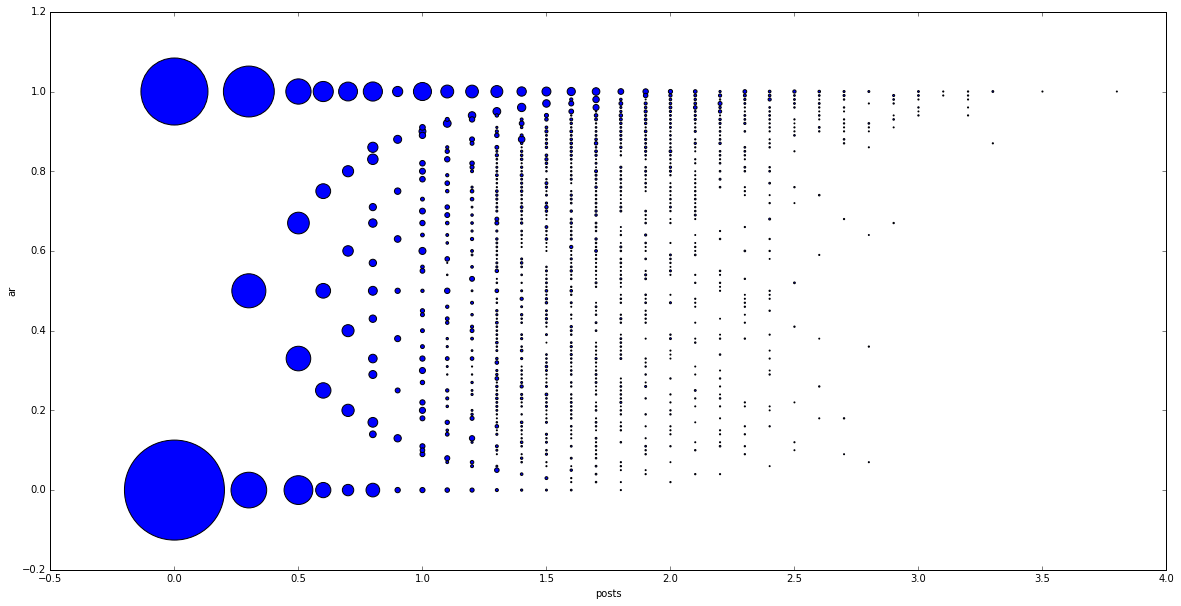

In [14]:
pl_users = users.where(col('Location').like('%Poland%'))

pl_users_df = users_aq.withColumn('answer_rate', coalesce(col('sum(answer)') / col('all_posts'), lit(0))) \
    .withColumn('log10_posts', log10('all_posts')) \
    .join(pl_users, pl_users.Id == users_aq.OwnerUserId, 'leftsemi') \
    .select(round('answer_rate', 2).alias('ar'), round('log10_posts', 1).alias('posts')) \
    .groupBy('ar', 'posts').count().orderBy(desc('count')).toPandas()
    
pl_users_df.plot(x='posts', y='ar', kind='scatter', s=df['count'] / df['count'].max() * 10000)

The above chart applies to users from Poland. Users with the most answers ratio from Poland are:

In [15]:
users_aq.join(pl_users, pl_users.Id == users_aq.OwnerUserId) \
    .withColumn('answer_rate', coalesce(col('sum(answer)') / col('all_posts'), lit(0))) \
    .where(col('all_posts') > 1000) \
    .orderBy(desc('answer_rate')) \
    .select('Id', 'Location', 'DisplayName', 'sum(question)', 'sum(answer)').show()

+-------+-------------------+-----------------+-------------+-----------+
|     Id|           Location|      DisplayName|sum(question)|sum(answer)|
+-------+-------------------+-----------------+-------------+-----------+
|1832058|      Torun, Poland|            furas|         null|       1803|
|3832970|     Warsaw, Poland| Wiktor Stribiżew|         null|       6890|
| 402253|     Warsaw, Poland|             Mchl|         null|       1028|
|1393766|             Poland|           Pshemo|            2|       2140|
|1451635|             Poland|        Paweł Fus|            2|       1553|
|1279683|     Warsaw, Poland|      Marek Lipka|            2|       1052|
| 941240|    Wroclaw, Poland|    Wiktor Zychla|            3|       1331|
|2021935|     Krakow, Poland| Sebastian Bochan|            6|       2152|
| 605744|     Warsaw, Poland|Tomasz Nurkiewicz|           13|       2959|
| 471160|   Pruszków, Poland|          marcinj|           10|       1296|
| 126214|    Wroclaw, Poland|  Lennart

### Patient conversations

In [16]:
comments.groupBy('PostId').agg(count('*'), countDistinct('UserId')) \
    .orderBy(desc('count(1)')).show()

+--------+--------+----------------------+
|  PostId|count(1)|count(DISTINCT UserId)|
+--------+--------+----------------------+
|38892391|     176|                     2|
|18746930|     136|                    63|
| 8051161|     125|                    45|
|32240629|     119|                     2|
|29479702|     119|                    89|
|40473714|     118|                    48|
|19500892|     118|                     2|
|10380166|     114|                    46|
|21687077|     108|                    68|
|39894700|     108|                     2|
| 3279550|     105|                    39|
|11059803|     103|                     6|
|39315028|     102|                     4|
|21430831|     101|                     2|
| 2348881|      95|                     5|
| 4435775|      92|                     3|
|33494987|      92|                     8|
|  991310|      92|                     6|
|38314865|      92|                     2|
|19162868|      91|                     2|
+--------+-

The most patient conversation between two stackoverflow users has 176 comments: http://stackoverflow.com/questions/38846406/compare-2-datatables-and-result-missing-data/38892391#38892391

### The shortest time to first answer

In [17]:
questions = posts.where(col('PostTypeId') == 1).alias('q')
answers = posts.where(col('PostTypeId') == 2).alias('a')

time_to_answer = unix_timestamp('a.CreationDate') - unix_timestamp('q.CreationDate')

by_tag = questions.join(answers, col('q.Id') == col('a.ParentId')) \
    .where(col('q.OwnerUserId') != col('a.OwnerUserId')) \
    .groupBy('q.Id', 'q.Tags').agg(min(time_to_answer).alias('time_to_first_answer')) \
    .select(explode('Tags').alias('tag'), 'time_to_first_answer') \
    .groupBy('tag').agg(
        expr('percentile_approx(time_to_first_answer, 0.5)').alias('median_time_to_first_answer'), 
        count('*').alias('number_of_questions')).cache()

by_tag.show()

+--------------------+---------------------------+-------------------+
|                 tag|median_time_to_first_answer|number_of_questions|
+--------------------+---------------------------+-------------------+
|                .lib|                     1625.0|                 53|
|          agility.js|                  3646249.0|                  5|
|        allow-modals|                3.0061478E7|                  1|
|amazon-cognito-fa...|                    10217.0|                 11|
|      android-alarms|                     1199.0|                714|
|    android-manifest|                     1030.0|               3207|
|    android-security|                    21652.0|                138|
|android-shortcutm...|                      740.0|                  3|
|       angular-chart|                     4986.0|                135|
|           arguments|                      534.0|               5786|
|       ariatemplates|                    74944.0|                 10|
|  arr

In [18]:
by_tag.where(col('number_of_questions') > 1000) \
    .orderBy('median_time_to_first_answer').show(truncate=False)

+------------------+---------------------------+-------------------+
|tag               |median_time_to_first_answer|number_of_questions|
+------------------+---------------------------+-------------------+
|sizeof            |243.0                      |1261               |
|jquery-selectors  |266.0                      |7442               |
|ternary-operator  |283.0                      |1186               |
|operators         |291.0                      |4741               |
|final             |304.0                      |1110               |
|this              |314.0                      |3600               |
|list-comprehension|326.0                      |2563               |
|int               |330.0                      |6760               |
|void              |332.0                      |1131               |
|addclass          |332.0                      |1185               |
|equals            |334.0                      |2107               |
|logical-operators |343.0         

In [19]:
by_tag.where(col('tag').isin('java', 'scala', 'python', 'r')) \
    .orderBy('median_time_to_first_answer').show(truncate=False)

+------+---------------------------+-------------------+
|tag   |median_time_to_first_answer|number_of_questions|
+------+---------------------------+-------------------+
|java  |913.0                      |998604             |
|python|1052.0                     |588856             |
|r     |1751.0                     |137115             |
|scala |3050.0                     |52600              |
+------+---------------------------+-------------------+

